# **PRÁCTICA 2: AUTOENCODERS - Parte 2: Convolucionales**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos

## **Ejercicio 2: Aplícalo para limpieza de ruido**
---

<p align="justify">Pongamos nuestro codificador automático convolucional a trabajar en un problema de eliminación de ruido de imagen. Es simple: entrenaremos al codificador automático para mapear imágenes de dígitos ruidosos para imágenes de dígitos limpios.</p>

<p align="justify">Así es como generaremos dígitos ruidosos sintéticos: simplemente aplicamos una matriz de ruido gaussiano y recortamos las imágenes entre 0 y 1.</p>

In [1]:
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from keras import layers
from keras.callbacks import TensorBoard

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

11490434/11490434 [==============================] - 0s 0us/step


<p align="justify">Así es como se ven los dígitos ruidosos:</p>

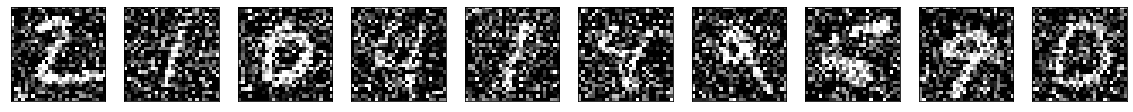

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<p align="justify">Si entrecierras los ojos, aún puedes reconocerlos, pero apenas. ¿Puede nuestro autocodificador aprender a recuperar los dígitos originales? Vamos a averiguar. En comparación con el codificador automático convolucional anterior, para mejorar la calidad de la reconstrucción, usaremos un modelo ligeramente diferente con más filtros por capa:</p>

In [4]:
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded_noisy = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_noisy)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded_noisy = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_noisy = keras.Model(input_img, decoded_noisy)
autoencoder_noisy.compile(optimizer='adam', loss='binary_crossentropy')

<p align="justify">Entrenémoslo para 100 épocas:</p>

In [5]:
autoencoder_noisy.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
469/469 [==============================] - 14s 8ms/step - loss: 0.1660 - val_loss: 0.1199
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1155 - val_loss: 0.1104
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1095 - val_loss: 0.1067
Epoch 4/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1063 - val_loss: 0.1043
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1040 - val_loss: 0.1025
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.1025 - val_loss: 0.1011
Epoch 7/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1013 - val_loss: 0.1013
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1003 - val_loss: 0.0995
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0995 - val_loss: 0.0985
Epoch 10/100
469/469 [==============================] - 4s 7ms/step - loss: 0.0989 - val_l

<p align="justify">Ahora echemos un vistazo a los resultados. Arriba, los dígitos ruidosos alimentados a la red, y abajo, los dígitos son reconstruidos por la red.</p>

313/313 [==============================] - 1s 2ms/step


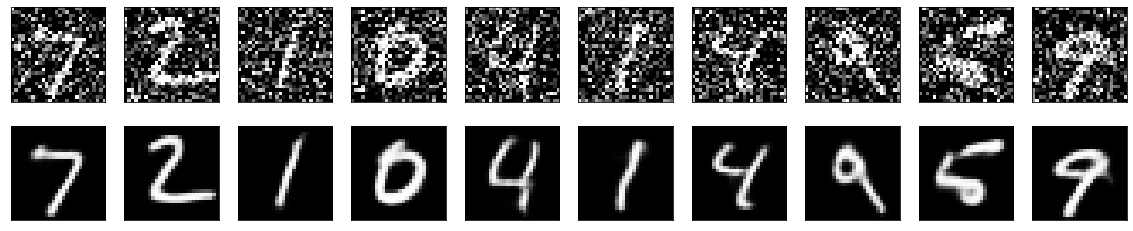

In [6]:
import matplotlib.pyplot as plt

encoded_imgs = autoencoder_noisy.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<p align="justify">Continuando con la convolucional del laboratorio, vamos a ver si existen outliers sin meterle ruido. Realizamos los mismos pasos que en los apartados de la Parte 1 de detección de anomalías.</p>

In [8]:
decoded_imgs3 = autoencoder_noisy.predict(x_test)
error_tes = np.mean(np.abs(x_test-decoded_imgs3)**2,tuple(range(1, decoded_imgs3.ndim)))

313/313 [==============================] - 1s 2ms/step


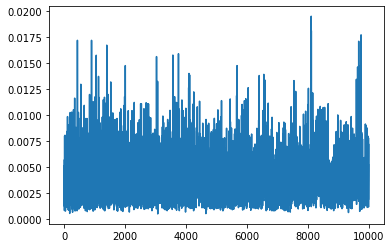

In [9]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.figure
plt.plot(error_tes,label="error_test")

In [11]:
#Seleccionar el threshold a partir del error de reconstrucción (por ejemplo  error_test > 0.04)
img_anomala=error_tes>0.0150
# Nos devuelve los indices que dan TRUE
index_anomalies=np.where(img_anomala)[0]
print(index_anomalies)

[ 431  895 1050 1395 3030 3567 3751 8112 8116 9672 9750]


<p align="justify">Mostramos las imágenes con mayor error de reconstrucción en la base de datos.</p>

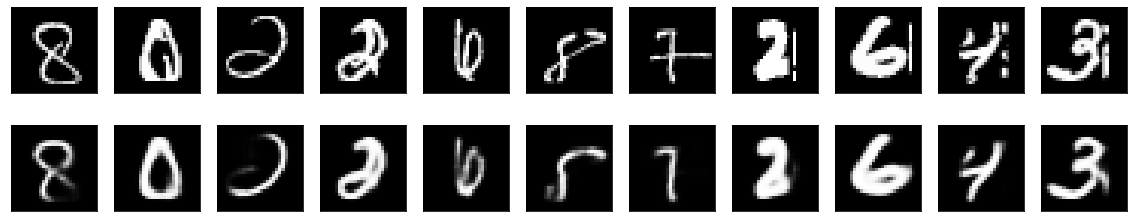

In [14]:
import matplotlib.pyplot as plt

j=0
plt.figure(figsize=(20, 4))
for i in index_anomalies:
    # display original
    ax = plt.subplot(2, len(index_anomalies), j + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, len(index_anomalies), j + 1 + len(index_anomalies))
    plt.imshow(decoded_imgs3[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=j+1
plt.show()